In [1]:
from read_alignment import readAlignment
import helperFxns_new as kim_helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
import networkx as nx


## clean combined alignments

In [2]:
def rewrite_header_fasta(input_fasta, output_fasta):
    with open(output_fasta, "w") as out_f:
        for i, record in enumerate(SeqIO.parse(input_fasta, "fasta"), start=1):
            record.id = f"seq{i}"
            record.description = ""  # Remove any additional description
            SeqIO.write(record, out_f, "fasta")

    print("Headers updated successfully!")



def clean_fasta(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        fasta_dict = {}
        header = None
        for line in infile:
            line = line.strip()  # Remove leading/trailing whitespace (including erroneous newlines)
            if line.startswith(">"):  # New header
                header = line
                fasta_dict[header] = []
            elif header:  # Sequence line
                fasta_dict[header].append(line)

        # Write cleaned FASTA
        for header, seq_list in fasta_dict.items():
            outfile.write(f"{header}\n{''.join(seq_list)}\n")  # Concatenated sequence in one line

def compute_avg_seq_identity(smat):
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    return avg_identity


def plot_avg_seq_identity_histogram(smat, bins=50):
    """ Given a sequence identity matrix, plot a histogram of the average pairwise sequence identity for each sequence. """
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(avg_identity, bins=bins, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Average Pairwise Sequence Identity")
    plt.ylabel("Density")
    plt.title("Histogram of Average Pairwise Sequence Identity")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


In [3]:
# clean_fasta("data/all_alignment.fa", "data/all_alignment.fasta")


In [4]:
combined_alignment = readAlignment('data/raw/all_alignment.fasta')
print('len of sequences:', len(combined_alignment))

arr_num = kim_helper.lett2num(combined_alignment, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)

hd = np.arange(0, len(arr_num))

print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)

len of sequences: 1070
arr_num shape: (1070, 2922)
seq shape before filtering: (1070, 2922)
seq shape after filtering: (1039, 443)


In [5]:
len(hFilt)

1039

In [6]:
# separate natural and mpnn sequences
seqFilt_nat = []
seqFilt_synth = []
synth_threshold = 970

for i in range(seqFilt.shape[0]):
  if hFilt[i] >= synth_threshold:
    seqFilt_synth.append(seqFilt[i])
  else:
    seqFilt_nat.append(seqFilt[i])

seqFilt_nat = np.array(seqFilt_nat)
seqFilt_synth = np.array(seqFilt_synth)

In [7]:
# compute the one-hot encoding 
one_hot_filtered_nat = kim_helper.alg2bin(seqFilt_nat)
print('one hot after filtering natural:', one_hot_filtered_nat.shape)

# compute the one-hot encoding 
one_hot_filtered_mpnn = kim_helper.alg2bin(seqFilt_synth)
print('one hot after filtering mpnn:', one_hot_filtered_mpnn.shape)


one hot after filtering natural: (939, 9303)
one hot after filtering mpnn: (100, 9303)


## **Co-variance Matrix** 

In [8]:
def rewrite_header_fasta(input_fasta, output_fasta):
    with open(output_fasta, "w") as out_f:
        for i, record in enumerate(SeqIO.parse(input_fasta, "fasta"), start=1):
            record.id = f"seq{i}"
            record.description = ""  # Remove any additional description
            SeqIO.write(record, out_f, "fasta")

    print("Headers updated successfully!")



def clean_fasta(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        fasta_dict = {}
        header = None
        for line in infile:
            line = line.strip()  # Remove leading/trailing whitespace (including erroneous newlines)
            if line.startswith(">"):  # New header
                header = line
                fasta_dict[header] = []
            elif header:  # Sequence line
                fasta_dict[header].append(line)

        # Write cleaned FASTA
        for header, seq_list in fasta_dict.items():
            outfile.write(f"{header}\n{''.join(seq_list)}\n")  # Concatenated sequence in one line

def compute_avg_seq_identity(smat):
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    return avg_identity


def plot_avg_seq_identity_histogram(smat, bins=50):
    """ Given a sequence identity matrix, plot a histogram of the average pairwise sequence identity for each sequence. """
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(avg_identity, bins=bins, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Average Pairwise Sequence Identity")
    plt.ylabel("Density")
    plt.title("Histogram of Average Pairwise Sequence Identity")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


def compute_lxl_cov(one_hot_matrix, L):
    """
    Computes an L x L covariance matrix from a one-hot encoded matrix.
    
    Parameters:
    one_hot_matrix : numpy array of shape (20*L, M)
        One-hot encoded representation of M amino acid sequences of length L.
    L : int
        Sequence length.
    
    Returns:
    C_lxl : numpy array of shape (L, L)
        L x L covariance matrix capturing positional correlations.
    """
    M = one_hot_matrix.shape[1]  # Number of sequences
    
    # Compute empirical frequency matrix
    #S = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    #print(S.shape)

    C = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    print(C.shape)
    
    # Compute mean frequency
    #p = np.mean(one_hot_matrix, axis=1, keepdims=True)
    # print(p.shape)
    
    # Compute covariance matrix
    #C = P - p @ p.T
    
    # Reshape into L x L blocks of size 20x20
    C_lxl = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            C_block = C[i*21:(i+1)*21, j*21:(j+1)*21]
            C_lxl[i, j] = np.linalg.norm(C_block, ord='fro') #Frobenius norm

    return C_lxl

In [9]:
print('one hot after filtering:', one_hot_filtered_mpnn.shape)
one_hot_filtered_mpnn_np = one_hot_filtered_mpnn.toarray()
L = int(one_hot_filtered_mpnn_np.shape[1]/21)
C_lxl_cov_mpnn = compute_lxl_cov(one_hot_filtered_mpnn_np.T, L)


one hot after filtering: (100, 9303)
(9303, 9303)


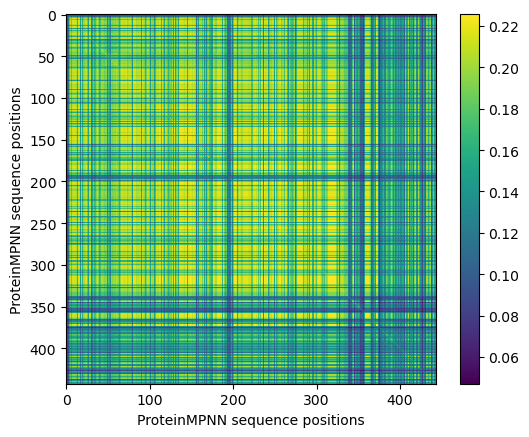

In [10]:
plt.imshow(C_lxl_cov_mpnn)
plt.colorbar()
plt.xlabel('ProteinMPNN sequence positions')
plt.ylabel('ProteinMPNN sequence positions')
plt.savefig('figs/final/support/mpnn_protein_cov.pdf', format='pdf', dpi=300)
# plt.savefig('real_protein_cov.png', dpi=300)

natural seq

one hot after filtering: (939, 9303)
(9303, 9303)


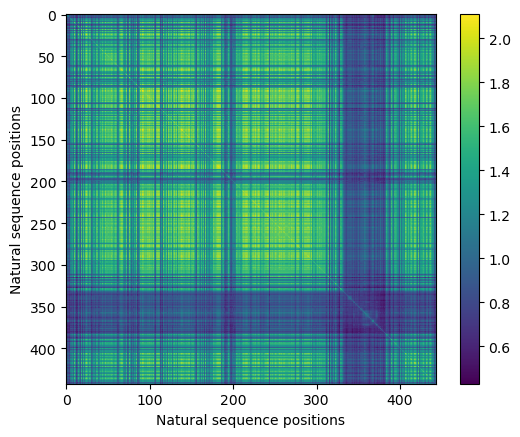

In [11]:
print('one hot after filtering:', one_hot_filtered_nat.shape)
one_hot_filtered_nat_np = one_hot_filtered_nat.toarray()
L = int(one_hot_filtered_nat_np.shape[1]/21)
C_lxl_cov_nat = compute_lxl_cov(one_hot_filtered_nat_np.T, L)

plt.imshow(C_lxl_cov_nat)
plt.colorbar()
plt.xlabel('Natural sequence positions')
plt.ylabel('Natural sequence positions')
plt.savefig('figs/final/support/natural_protein_cov.pdf', format='pdf', dpi=300)
# plt.savefig('real_protein_cov.png', dpi=300)

C_cov_mpnn_flat shape: (196249,)
C_cov_reak_flat shape: (196249,)


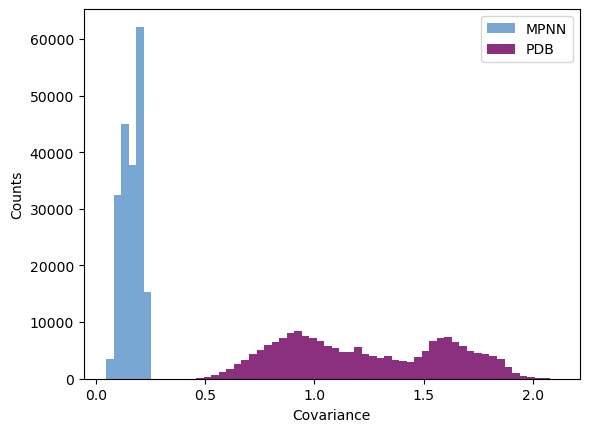

In [32]:
# histograms
C_cov_mpnn_flat = C_lxl_cov_mpnn.flatten()
print('C_cov_mpnn_flat shape:', C_cov_mpnn_flat.shape)
C_cov_real_flat = C_lxl_cov_nat.flatten()
print('C_cov_reak_flat shape:', C_cov_real_flat.shape)

# plt.hist([C_cov_mpnnn_flat, C_cov_real_flat], bins=40, stacked=True, label=['MPNN', 'Real'], color=['#79a7d3', '#8a307f'], alpha=0.7)
plt.hist([C_cov_mpnn_flat, C_cov_real_flat], bins=60, stacked=True, label=['MPNN', 'PDB'], color=['#79a7d3', '#8a307f'])
plt.xlabel('Covariance')
plt.ylabel('Counts')
plt.legend()

# plt.savefig('figs/final/support/hist_cov_mat.pdf', format='pdf', dpi=300)
plt.show()

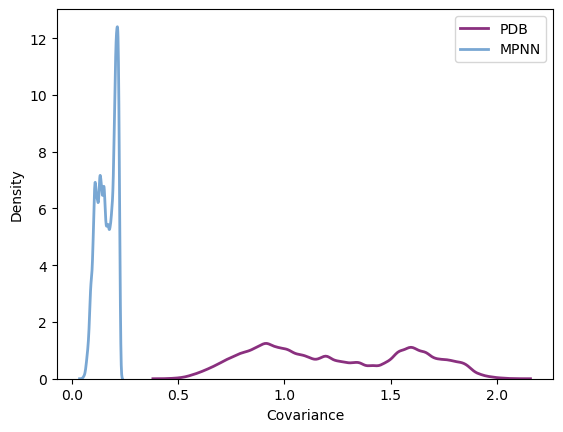

In [13]:
# sns.kdeplot(C_cov_real_flat, label='Real KDE', color='#8a307f', linewidth=2, fill=True)
# sns.kdeplot(C_cov_mpnnn_flat, label='MPNN KDE', color='#79a7d3', linewidth=2, fill=True)
sns.kdeplot(C_cov_real_flat, label='PDB', color='#8a307f', linewidth=2, bw_adjust=0.5)
sns.kdeplot(C_cov_mpnnn_flat, label='MPNN', color='#79a7d3', linewidth=2)

plt.xlabel('Covariance')
plt.ylabel('Density')
plt.legend()

# plt.savefig('figs/final/support/kde_cov_mat.pdf', format='pdf', dpi=300)

### permutation testing

In [14]:
import numpy as np
from scipy.stats import permutation_test
# Sample data for two groups
group1 = C_cov_real_flat.copy()
group2 = C_cov_mpnnn_flat.copy()
# Define the test statistic (e.g., difference of means)
def test_statistic(x, y):
    return np.mean(x) - np.mean(y)
# Perform the permutation test
result = permutation_test((group1, group2), test_statistic, n_resamples=1000, alternative='two-sided')
# Output the results
print("P-value:", result.pvalue)
print("Test statistic:", result.statistic)

P-value: 0.001998001998001998
Test statistic: 1.0702107761325526


In [15]:
# import numpy as np

# # Assuming C_cov_real_flat and C_cov_mpnnn_flat are 1D arrays of covariance values
# # Compute observed difference in covariance
# obs_diff = np.mean(C_cov_real_flat) - np.mean(C_cov_mpnnn_flat)

# # Permutation test setup
# n_permutations = 50000
# perm_diffs = np.zeros(n_permutations)

# # Combine both datasets
# combined = np.concatenate([C_cov_real_flat, C_cov_mpnnn_flat])

# for i in range(n_permutations):
#     if i % 1000 == 0: print(i)
#     np.random.shuffle(combined)  # Shuffle combined data
#     perm_real = combined[:len(C_cov_real_flat)]
#     perm_mpnn = combined[len(C_cov_real_flat):]
#     perm_diffs[i] = np.mean(perm_real) - np.mean(perm_mpnn)

# # Compute p-value (two-tailed test)
# p_value = np.mean((perm_diffs >= obs_diff) | (perm_diffs <= -obs_diff))

# print(f"Observed Covariance Difference: {obs_diff:.5f}")
# print(f"Permutation Test p-value: {p_value:.5f}")


## **Mutual information**

In [16]:
def compute_lxl_mi(one_hot_matrix, L):
    """
    Computes an L x L covariance matrix from a one-hot encoded matrix.
    
    Parameters:
    one_hot_matrix : numpy array of shape (20*L, M)
        One-hot encoded representation of M amino acid sequences of length L.
    L : int
        Sequence length.
    
    Returns:
    C_lxl : numpy array of shape (L, L)
        L x L covariance matrix capturing positional correlations.
    """
    M = one_hot_matrix.shape[1]  # Number of sequences
    
    # Compute empirical frequency matrix
    #S = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    #print(S.shape)

    C = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    print(C.shape)
    
    # Compute mean frequency
    #p = np.mean(one_hot_matrix, axis=1, keepdims=True)
    # print(p.shape)
    
    # Compute covariance matrix
    #C = P - p @ p.T
    
    # Reshape into L x L blocks of size 20x20
    C_lxl = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            C_block = C[i*21:(i+1)*21, j*21:(j+1)*21]
            mi = mutual_info_regression(np.ravel(C_block[0]).reshape(-1, 1), np.ravel(C_block[1].reshape(-1, 1)), discrete_features=[False]) #mutual info score
            # mi = mutual_info_regression(np.ravel(C_block[0]).reshape(-1, 1), np.ravel(C_block[1].reshape(-1, 1)), discrete_features=[False]) #mutual info score
            C_lxl[i, j] = mi[0]


    return C_lxl

In [17]:
# L = int(one_hot_filtered_nat_np.shape[1]/21)
# C_lxl_real = compute_lxl_mi(one_hot_filtered_nat_np.T, L)

# load from saved npy
C_lxl_real = np.load('data/derivatives/mi_lxl_natural.npy')


Text(70.72222222222221, 0.5, 'Natural sequence positions')

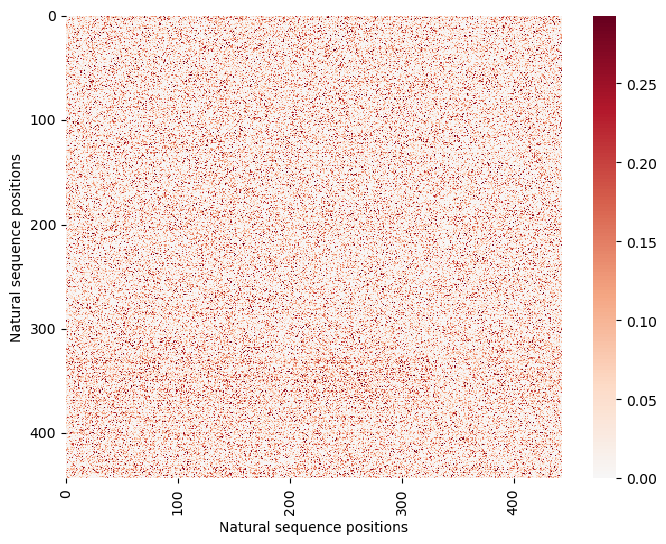

In [18]:
# plt.imshow(C_lxl_real)
plt.figure(figsize=(8, 6))

ax = sns.heatmap(C_lxl_real, cmap="RdBu_r", center=0, vmax=np.percentile(C_lxl_real, 99), vmin=np.percentile(C_lxl_real, 1))


# Set x and y ticks every 100
tick_positions = np.arange(0, C_lxl_real.shape[0], 100)
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(tick_positions)
ax.set_yticklabels(tick_positions)

plt.xlabel('Natural sequence positions')
plt.ylabel('Natural sequence positions')

# plt.savefig('figs/final/support/mi_real_heatmap.pdf', format='pdf', dpi=300)

In [19]:
# mpnn mutual information
# L = int(one_hot_filtered_mpnn_np.shape[1] / 21)
# C_lxl_mpnn = compute_lxl_mi(one_hot_filtered_mpnn_np.T, L)

# load from saved npy
C_lxl_mpnn = np.load('data/derivatives/mi_lxl_mpnn.npy')


Text(70.72222222222221, 0.5, 'ProteinMPNN sequence positions')

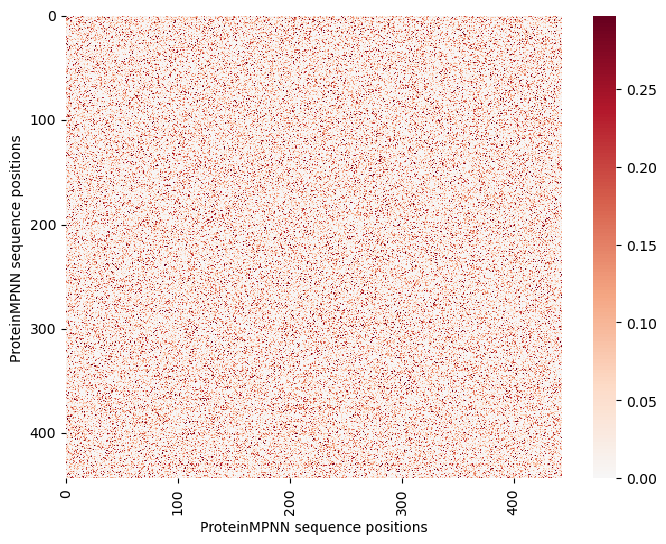

In [20]:
plt.figure(figsize=(8, 6))

ax = sns.heatmap(C_lxl_mpnn, cmap="RdBu_r", center=0, vmax=np.percentile(C_lxl_mpnn, 99), vmin=np.percentile(C_lxl_mpnn, 1))


# Set x and y ticks every 100
tick_positions = np.arange(0, C_lxl_mpnn.shape[0], 100)
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(tick_positions)
ax.set_yticklabels(tick_positions)

plt.xlabel('ProteinMPNN sequence positions')
plt.ylabel('ProteinMPNN sequence positions')

# plt.savefig('figs/final/support/mi_mpnn_heatmap.pdf', format='pdf', dpi=300)

flat matrix shape: (196249,)
flat matrix shape: (196249,)


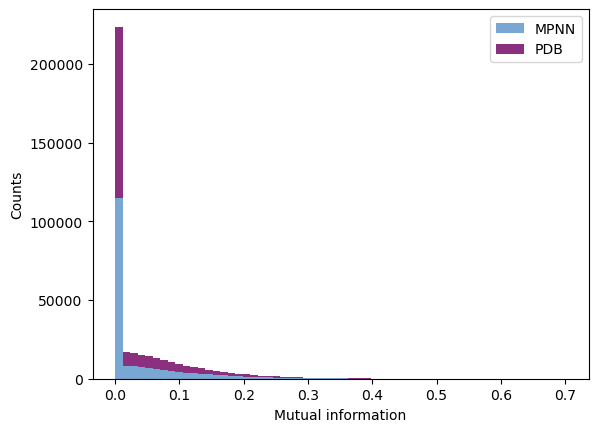

In [21]:
C_mpnn_flat = C_lxl_mpnn.flatten()
print('flat matrix shape:', C_mpnn_flat.shape)
C_real_flat = C_lxl_real.flatten()
print('flat matrix shape:', C_real_flat.shape)

plt.hist([C_mpnn_flat, C_real_flat], bins=60, stacked=True, label=['MPNN', 'PDB'], color=['#79a7d3', '#8a307f'])
plt.xlabel('Mutual information')
plt.ylabel('Counts')
plt.legend()

# plt.savefig('figs/final/support/mi_hist_original.pdf', format='pdf', dpi=300)
plt.show()

flat matrix shape: (82697,)
flat matrix shape: (88748,)


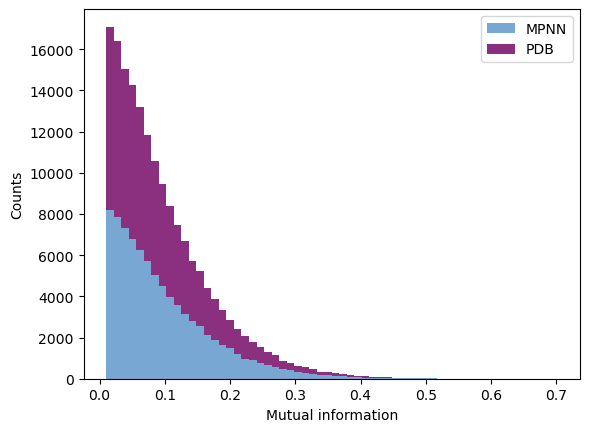

In [22]:
C_mpnn_large_mi_flat = C_mpnn_flat[C_mpnn_flat>0.01]
print('flat matrix shape:', C_mpnn_large_mi_flat.shape)
C_real_large_mi_flat = C_real_flat[C_real_flat>0.01]
print('flat matrix shape:', C_real_large_mi_flat.shape)

plt.hist([C_mpnn_large_mi_flat, C_real_large_mi_flat], bins=60, stacked=True, label=['MPNN', 'PDB'], color=['#79a7d3', '#8a307f'])

plt.xlabel('Mutual information')
plt.ylabel('Counts')
plt.legend()

# plt.savefig('figs/final/support/mi_hist_cropped.pdf', format='pdf', dpi=300)
plt.show()

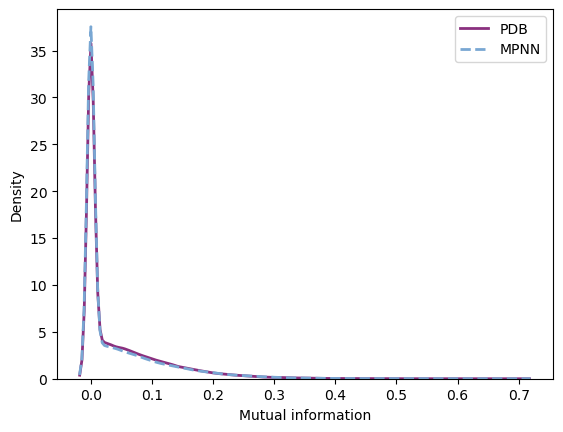

In [23]:
sns.kdeplot(C_real_flat, label='PDB', color='#8a307f', linewidth=2, linestyle='-')  # Solid line
sns.kdeplot(C_mpnn_flat, label='MPNN', color='#79a7d3', linewidth=2, linestyle='--')  # Dashed line


plt.xlabel('Mutual information')
plt.ylabel('Density')

plt.legend()
# plt.savefig('figs/final/support/kde_uncropped_mi.pdf', format='pdf', dpi=300)


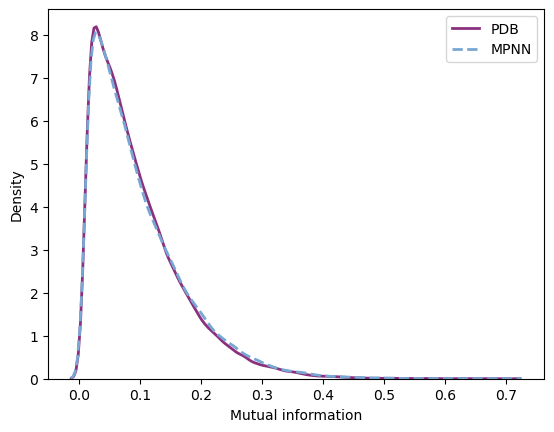

In [24]:
sns.kdeplot(C_real_large_mi_flat, label='PDB', color='#8a307f', linewidth=2, linestyle='-')  # Solid line
sns.kdeplot(C_mpnn_large_mi_flat, label='MPNN', color='#79a7d3', linewidth=2, linestyle='--')  # Dashed line


plt.xlabel('Mutual information')
plt.ylabel('Density')

plt.legend()
# plt.savefig('figs/final/support/kde_mi.pdf', format='pdf', dpi=300)


### permutation testing

In [25]:
import numpy as np
from scipy.stats import permutation_test
# Sample data for two groups
group1 = C_real_large_mi_flat.copy()
group2 = C_mpnn_large_mi_flat.copy()
# Define the test statistic (e.g., difference of means)
def test_statistic(x, y):
    return np.mean(x) - np.mean(y)
# Perform the permutation test
result = permutation_test((group1, group2), test_statistic, n_resamples=1000, alternative='two-sided')
# Output the results
print("P-value:", result.pvalue)
print("Test statistic:", result.statistic)

P-value: 0.001998001998001998
Test statistic: -0.002556507110813594


In [26]:
# # uncropped (original) mutual infos
# real_coevo_values = C_real_flat.copy()
# mpnn_coevo_values = C_mpnn_flat.copy()

# # Assuming C_cov_real_flat and C_cov_mpnnn_flat are 1D arrays of covariance values
# # Compute observed difference in covariance
# obs_diff = np.mean(real_coevo_values) - np.mean(mpnn_coevo_values)

# # Permutation test setup
# n_permutations = 50000
# perm_diffs = np.zeros(n_permutations)

# # Combine both datasets
# combined = np.concatenate([mpnn_coevo_values, real_coevo_values])

# for i in range(n_permutations):
#     if i % 1000 == 0: print(i)
#     np.random.shuffle(combined)  # Shuffle combined data
#     perm_real = combined[:len(real_coevo_values)]
#     perm_mpnn = combined[len(real_coevo_values):]
#     perm_diffs[i] = np.mean(perm_real) - np.mean(perm_mpnn)

# # Compute p-value (two-tailed test)
# p_value = np.mean((perm_diffs >= obs_diff) | (perm_diffs <= -obs_diff))
# print(f"Observed Covariance Difference: {obs_diff:.5f}")
# print(f"Permutation Test p-value: {p_value:.5f}")


(array([1.51155e+05, 2.55730e+04, 1.20390e+04, 4.89700e+03, 1.75800e+03,
        5.81000e+02, 1.78000e+02, 4.90000e+01, 1.50000e+01, 4.00000e+00]),
 array([0.        , 0.07011035, 0.14022071, 0.21033106, 0.28044141,
        0.35055177, 0.42066212, 0.49077248, 0.56088283, 0.63099318,
        0.70110354]),
 <BarContainer object of 10 artists>)

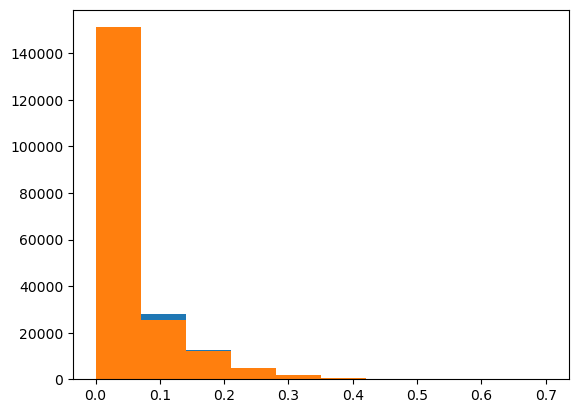

In [27]:
plt.hist(C_real_flat)
plt.hist(C_mpnn_flat)

# am i tripping?

In [33]:

import numpy as np
from scipy.stats import permutation_test
# Sample data for two groups
group1 = C_cov_real_flat.copy()
group2 = C_cov_mpnn_flat.copy()
# Define the test statistic (e.g., difference of means)
def test_statistic(x, y):
    return np.mean(x) - np.mean(y)
# Perform the permutation test
result = permutation_test((group1, group2), test_statistic, n_resamples=500, alternative='two-sided')
# Output the results
print("P-value:", result.pvalue)
print("Test statistic:", result.statistic)

P-value: 0.003992015968063872
Test statistic: 1.0702107761325526


In [34]:
import numpy as np
from scipy.stats import permutation_test
# Sample data for two groups
group1 = C_real_flat.copy()
group2 = C_mpnn_flat.copy()
# Define the test statistic (e.g., difference of means)
def test_statistic(x, y):
    return np.mean(x) - np.mean(y)
# Perform the permutation test
result = permutation_test((group1, group2), test_statistic, n_resamples=500, alternative='two-sided')
# Output the results
print("P-value:", result.pvalue)
print("Test statistic:", result.statistic)

P-value: 0.003992015968063872
Test statistic: 0.00189921139636752


In [35]:
import numpy as np
from scipy.stats import permutation_test
# Sample data for two groups
group1 = C_real_flat.copy()
group2 = C_mpnn_flat.copy()
# Define the test statistic (e.g., difference of means)
def test_statistic(x, y):
    return np.mean(x) - np.mean(y)
# Perform the permutation test
result = permutation_test((group1, group2), test_statistic, n_resamples=500, alternative='two-sided')
# Output the results
print("P-value:", result.pvalue)
print("Test statistic:", result.statistic)

P-value: 0.003992015968063872
Test statistic: 0.00189921139636752


In [ ]:
import numpy as np
from scipy.stats import permutation_test
# Sample data for two groups
group1 = C_real_large_mi_flat.copy()
group2 = C_mpnn_large_mi_flat.copy()
# Define the test statistic (e.g., difference of means)
def test_statistic(x, y):
    return np.mean(x) - np.mean(y)
# Perform the permutat ion test
result = permutation_test((group1, group2), test_statistic, n_resamples=500, alternative='two-sided')
# Output the results
print("P-value:", result.pvalue)
print("Test statistic:", result.statistic)

P-value: 0.003992015968063872
Test statistic: -0.002556507110813594
